In [1]:
import importlib
from torch import nn
from tqdm import tqdm as tqdm
import matplotlib.pyplot as plt
import sys
sys.path.append('../src')
import torch.nn.functional as F
import pytorch_lightning as pl
from torchmetrics.functional import accuracy
from torch.utils.data import DataLoader, TensorDataset, Dataset, Subset
import datetime
from sklearn.metrics import roc_auc_score

import torch
from torchvision import transforms
import pandas as pd
import seaborn as sn
import src.distance_metrics

import src.ood_detection
import numpy as np
from scipy.stats import multivariate_normal
from sklearn.covariance import EmpiricalCovariance, GraphicalLasso
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans 
import statsmodels.api as sm 
from scipy import stats
import pandas as pd
import seaborn as sns
from distfit import distfit
from scipy.stats import gamma
import scipy.stats as stats
import src.datasets

import os
from PIL import Image
import h5py
import torch.optim as optim
from pathlib import Path
from typing import List, Tuple, Optional, Dict, Any, Sequence
import math




c:\Users\rooben\anaconda3\envs\sanuberto\lib\site-packages\torchaudio\backend\utils.py:62: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
def preprocess_images(input_dir, output_dir):
    with h5py.File(os.path.join(input_dir, '3dshapes.h5'), 'r') as dataset:
        data = dataset['images'][:]  # Assuming this fits into memory; otherwise, process in chunks.
    
    # Resize images (example using OpenCV for batch processing could be faster)
    resized_images = np.array([np.array(Image.fromarray(img).resize((32, 32))) for img in data])

    # Save preprocessed data
    with h5py.File(os.path.join(output_dir, '3dshapes_preprocessed.h5'), 'w') as f:
        f.create_dataset('images', data=resized_images)
#preprocess_images("../data/Fast_3DShapes/raw","../data/Fast_3DShapes/processed")

In [2]:
def denormalize(normalized, basis):
    return basis.min() + (basis.max() - basis.min())*((normalized + 1)/2)

def normalize(unnormalized, basis):
    return (2 * (unnormalized - basis.min()) / (basis.max() - basis.min()) - 1)

def normalize_feat_wise(unnormalized, basis):
    return (2 * (unnormalized - basis.min(0)) / (basis.max(0) - basis.min(0)) - 1)

def denormalize_feat_wise(normalized, basis):
    return basis.min(0) + (basis.max(0) - basis.min(0))*((normalized + 1)/2)

def denormalize_std(normalized, basis):
    return normalized * basis.std(0) + basis.mean(0)

def normalize_std(unnormalized, basis):
    return (unnormalized - basis.mean(0))/basis.std(0)

def feature_normalize(X, axis=1, eps=1e-12):
    """Normalize along axis (rows if axis=1) with numerical stability. From mahalanobis ++"""
    X = np.asarray(X)
    norms = np.linalg.norm(X, ord=2, axis=axis, keepdims=True)
    return X / np.clip(norms, eps, None)



In [3]:
def show_images_grid(
    data,
    filenames: Sequence[str],
    max_cols: int = 10,
    titles: Optional[Sequence[str]] = None,
    figsize_per_cell: float = 2.0,
    turn_off_axes: bool = True,
    save_path: Optional[str] = None,
):
    """
    Display images in a grid with up to `max_cols` columns.

    Args:
        root: Root directory for images (can be "" if `filenames` are absolute).
        filenames: List of image paths (relative to `root`, or absolute paths).
        max_cols: Maximum number of columns in the grid.
        titles: Optional list of titles per image (same length as filenames).
        figsize_per_cell: Size multiplier for each cell in inches.
        turn_off_axes: If True, hides axes.
        save_path: If provided, saves the figure to this path.

    Returns:
        (fig, axes) from matplotlib for further customization.
    """
    
    paths = []
    infos = []
    for name in filenames:
        p = int(name.split("/")[2].split("_")[0])
        infos.append(name.split("/")[2])
        paths.append(p)

    # Load images (RGB), skipping missing ones with a warning
    imgs, kept_paths, kept_titles = [], [], []
    for i, p in enumerate(paths):
        try:
            img = data[p]
            imgs.append(img)
            kept_paths.append(infos[i])
            if titles is not None and i < len(titles):
                kept_titles.append(infos[i])
            else:
                kept_titles.append(None)
        except Exception as e:
            print(f"[warn] Could not load {p}: {e}")

    n = len(imgs)
    if n == 0:
        print("No images to display.")
        return None, None

    cols = min(max_cols, n)
    rows = math.ceil(n / cols)
    fig_w = max(1, cols * figsize_per_cell)
    fig_h = max(1, rows * figsize_per_cell)
    fig, axes = plt.subplots(rows, cols, figsize=(fig_w, fig_h))
    axes = np.array(axes, dtype=object).reshape(rows, cols)  # handles 1D cases

    idx = 0
    for r in range(rows):
        for c in range(cols):
            ax = axes[r, c]
            if idx < n:
                ax.imshow(imgs[idx])
                if turn_off_axes:
                    ax.axis("off")
                if kept_titles[idx]:
                    ax.set_title(str(kept_titles[idx]), fontsize=9)
            else:
                ax.axis("off")
            idx += 1

    plt.tight_layout()
    if save_path:
        Path(save_path).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, bbox_inches="tight", dpi=200)

    plt.show()

    return fig, axes


In [3]:
def split_names_to_dict(name_list, append = False, labels_dict = None ):
    if ~append:
        labels_dict = {"fh":[],"wh":[],"oh":[],"sc":[],"sh":[] ,"or":[] }
    for name in name_list:
        spltted_name = name.split("_")
        labels_dict["fh"].append(int(spltted_name[3][2:]))
        labels_dict["wh"].append(int(spltted_name[4][2:]))
        labels_dict["oh"].append(int(spltted_name[5][2:]))
        labels_dict["sc"].append(int(spltted_name[6][2:]))
        labels_dict["sh"].append(int(spltted_name[7][2:]))
        labels_dict["or"].append(int(spltted_name[8][2:].split(".")[0]))

    return labels_dict

In [17]:
with h5py.File(os.path.join("./shapes3d", '3dshapes.h5'), 'r') as dataset:
    data = dataset['images'][:]  # Assuming this fits into memory; otherwise, process in chunks.
    

In [104]:
epoch = 1
seed = "_s3" #_s2 : hue; s3 : or; s4: fh
shapes_te_names = np.load(f"./activations/shapes3d_SN{seed}/epoch{epoch}/resnet18_shapes3d_val_names.npy").flatten()
shapes_te_acts = np.load(f"./activations/shapes3d_SN{seed}/epoch{epoch}/resnet18_shapes3d_val.npy")
shapes_tr_names = np.load(f"./activations/shapes3d_SN{seed}/epoch{epoch}/resnet18_shapes3d_train_names.npy").flatten()
shapes_tr_acts = np.load(f"./activations/shapes3d_SN{seed}/epoch{epoch}/resnet18_shapes3d_train.npy")




In [95]:
tr_labels = split_names_to_dict(shapes_tr_names)

#### Generating the different train and test sets

In [81]:
uniq_vals = []
labels = ["fh", "wh","oh", "sc","sh","or"]
for lab in labels:
    uni = np.unique(tr_labels[lab])
    uniq_vals.append(uni)
    print(lab,uni)


fh [0 1 2 3 4 5 6 7 8 9]
wh [0 1 2 3 4 5 6 7 8 9]
oh [0 1 2 3 4 5 6 7 8 9]
sc [0 1 2 3 4 5 6 7]
sh [0 1 2 3]
or [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


In [91]:
codes = {}
ind = 0
for fh in uniq_vals[0]:
    for wh in uniq_vals[1]:
        for oh in uniq_vals[2]:
            for sc in uniq_vals[3]:
                for sh in uniq_vals[4]:
                    for or_ in uniq_vals[5]:
                        codes[f"fh{fh}_wh{wh}_oh{oh}_sc{sc}_sh{sh}_or{or_}"] = str(f"{ind:06d}")
                        ind += 1


In [92]:
codes["fh9_wh9_oh3_sc4_sh3_or9"]

'476934'

In [151]:
used_ids = np.zeros(480000)

In [154]:
path = './'

#save_path = './test_half_fh.txt'
#save_path = './test_half_hues.txt'

save_path = './test_all_or.txt'



prefix = 'images_classic/shapes_3d/'
#files = os.listdir(path)
np.random.seed(0)
duplicates = []
nr = 0
total = 70000
with open(save_path, 'w') as f:
    while nr < total:
        fh = np.random.randint(0,10) #normally 10
        wh = np.random.randint(0,10)
        oh = np.random.randint(0,10)
        sc = np.random.randint(0,8)
        sh = np.random.randint(0,4) #normally 4
        for or_ in range(15):
        #or_ = np.random.randint(0,15)
            fname = f"fh{fh}_wh{wh}_oh{oh}_sc{sc}_sh{sh}_or{or_}"
            i = codes[fname]
            if used_ids[int(i)] == 1:
                continue
            else:
                nr += 1
                used_ids[int(i)] = 1
            
            line = prefix + i + '_' + fname + ".png" + " " + str(sh) + '\n'
            f.write(line)
    f.close()

#### checking out the variability of one not-trained feature

In [105]:
one_feat_mas = (np.array(tr_labels["fh"]) == 4)*(np.array(tr_labels["sc"]) == 3)*(np.array(tr_labels["oh"]) == 3)*(np.array(tr_labels["sh"]) == 2)*(np.array(tr_labels["wh"]) == 9)
one_feat_mas.sum()

15

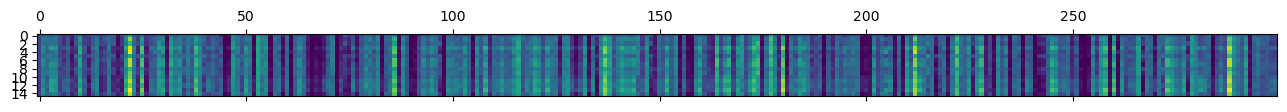

In [106]:
selected_acts = shapes_tr_acts[one_feat_mas]
plt.matshow(selected_acts.T[0:300].T)




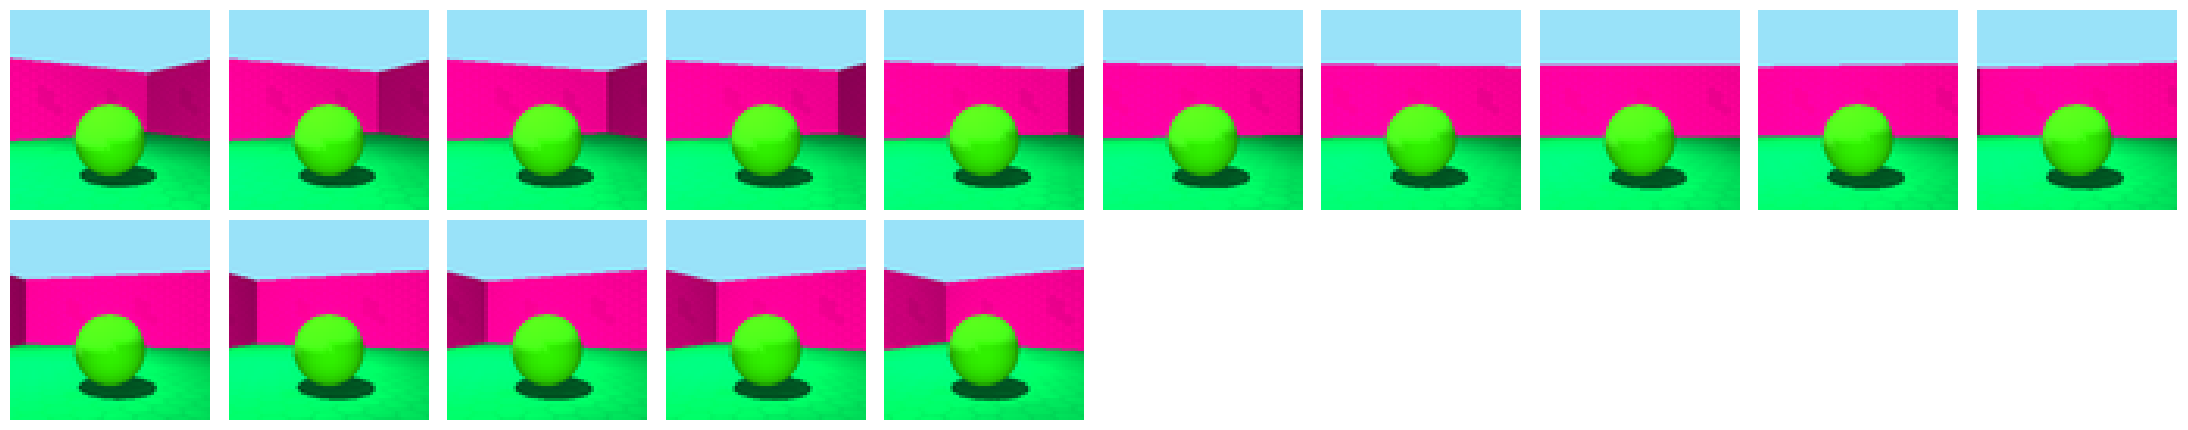

(<Figure size 2200x440 with 20 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>]], dtype=object))

In [107]:
# Show 30 images in up to 10 columns (i.e., 3 rows)
root = "./shapes3d"
selected_images = shapes_tr_names[one_feat_mas]
show_images_grid(data, selected_images, max_cols=10, figsize_per_cell=2.2)


In [108]:
selected_labels = np.array(split_names_to_dict(selected_images)["or"]).reshape(-1,1)

In [109]:
from sklearn.feature_selection import f_classif, mutual_info_classif

f_stats, p_vals = f_classif(shapes_tr_acts,tr_labels["or"])
#mi = mutual_info_classif(shapes_tr_acts,tr_labels["or"])



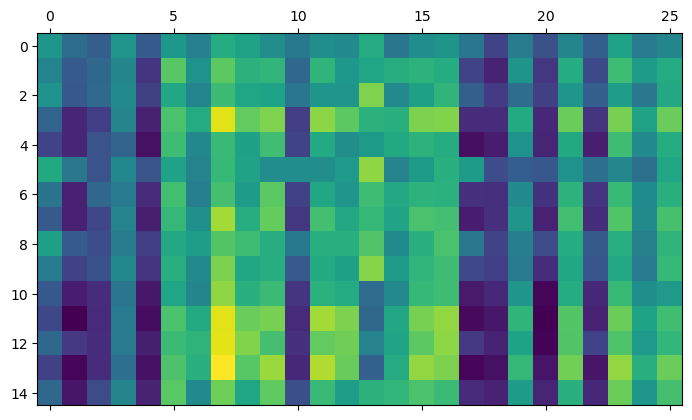

In [111]:
#mask = mi > np.quantile(mi,0.95)
#mask = mi < np.quantile(mi,0.01)
mask = f_stats < np.quantile(f_stats,0.05)

mask.sum()
plt.matshow(selected_acts.T[mask].T)

#plot_per_label_acts(label_name,epoch,mask = mask)
#plt.savefig(f"./figs/nosn/{label_name}_{epoch}.png")
 

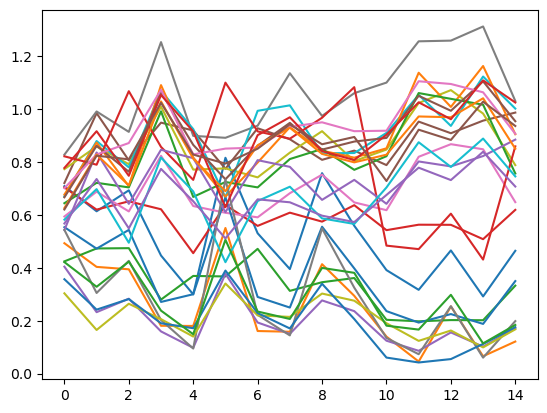

In [112]:
plt.plot(selected_labels,selected_acts.T[mask].T)

#### PLotting most importatnt neurons via diverse measures

In [7]:


def plot_per_label_acts(label_name, epoch, mask ):

    """ fh - floor hue
        wh - wall hues
        oh - object hue
        sc - scale
        sh - shape
        or - orientation    
    """
    fig,axs = plt.subplots(1,2, figsize = (20,20))
    shapes_names = np.load(f"./activations/shapes3d/epoch{epoch}/resnet18_shapes3d_val_names.npy").flatten()
    shapes_acts = np.load(f"./activations/shapes3d/epoch{epoch}/resnet18_shapes3d_val.npy")
    labels = split_names_to_dict(shapes_names)
    selected_acts =np.array([ np.concatenate([shapes_acts[np.array(labels[label_name]) == i][np.random.randint(0,sum(np.array(labels[label_name]) == i),50)],np.ones((1,512))*np.inf],0).T[mask].T for i in range(np.array(labels[label_name]).max() +1)]).reshape(-1,sum(mask))
    axs[0].matshow(selected_acts)
    axs[0].set_title(f"Without SN, {label_name} ")
    shapes_names = np.load(f"./activations/shapes3d_SN/epoch{epoch}/resnet18_shapes3d_val_names.npy").flatten()
    labels = split_names_to_dict(shapes_names)
    sn_shapes_acts = np.load(f"./activations/shapes3d_SN/epoch{epoch}/resnet18_shapes3d_val.npy")
    selected_acts_sn =np.array([ np.concatenate([sn_shapes_acts[np.array(labels[label_name]) == i][np.random.randint(0,sum(np.array(labels[label_name]) == i),50)],np.ones((1,512))*np.inf],0).T[mask].T for i in range(np.array(labels[label_name]).max() +1)]).reshape(-1,sum(mask))
    axs[1].matshow(selected_acts_sn)
    axs[1].set_title(f"With SN, {label_name}, epoch: {epoch}")
    plt.plot()
    


In [ ]:
plot_per_label_acts("or",1,mask = np.ones(512,dtype=bool))

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [272]:
from sklearn import linear_model
epoch = 20
shapes_names = np.load(f"./activations/shapes3d_SN/epoch{epoch}/resnet18_shapes3d_val_names.npy").flatten()
shapes_acts = np.load(f"./activations/shapes3d_SN/epoch{epoch}/resnet18_shapes3d_val.npy")
labels = split_names_to_dict(shapes_names)
clf = RandomForestClassifier(n_estimators=100)
y_val = np.array(labels["or"])
clf.fit(shapes_acts,y_val)
predictions = clf.predict(shapes_acts)
accuracy = accuracy_score(y_val, predictions)
print(accuracy)
mask = clf.feature_importances_ < np.quantile(clf.feature_importances_,0.05)


RandomForestClassifier()

In [23]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import numpy as np

pipe = make_pipeline(
    StandardScaler(),
    LogisticRegression(penalty="l1", solver="saga", C=1.0, max_iter=50)
)
label_name = "wh"
epoch = 1
shapes_names = np.load(f"./activations/shapes3d_SN/epoch{epoch}/resnet18_shapes3d_val_names.npy").flatten()
shapes_acts = np.load(f"./activations/shapes3d_SN/epoch{epoch}/resnet18_shapes3d_val.npy")
labels = split_names_to_dict(shapes_names)
y_val = np.array(labels[label_name])
#plot_per_label_acts(label_name,epoch,mask = mask)
pipe.fit(shapes_acts, y_val)
print("fitted")
# For binary: coef_.ravel(); for multiclass OvR: average |coef| across classes
coefs = pipe.named_steps["logisticregression"].coef_
importance = np.mean(np.abs(coefs), axis=0)  # shape: [n_features]
rank = np.argsort(importance)[::-1]


fitted


In [24]:
accuracy_score(pipe.predict(shapes_acts),y_val)

0.9721666666666666

In [25]:
from sklearn.inspection import permutation_importance
perm = permutation_importance(pipe, shapes_acts, y_val, n_repeats=20, n_jobs=-1, random_state=0)
perm_importance = perm.importances_mean


In [ ]:
mask = importance > np.quantile(importance,0.97)

plot_per_label_acts(label_name,epoch,mask )

In [ ]:
mask = perm_importance > np.quantile(perm_importance,0.97)

plot_per_label_acts(label_name,epoch,mask )

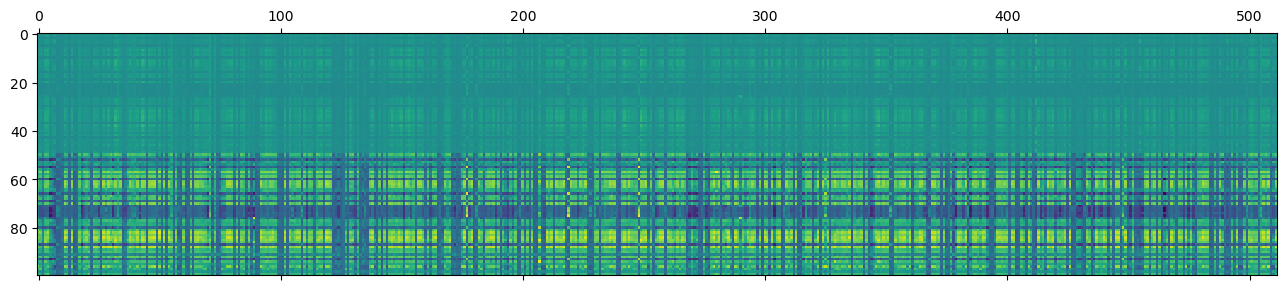

In [11]:
plt.matshow(np.concatenate([shapes_acts[0:50],normalize_std(shapes_acts,shapes_acts)[:50]],0))

In [5]:
from sklearn.feature_selection import f_classif, mutual_info_classif

epochs = [1,2,5,20]
label_names = ["fh","wh","sh","sc","oh","or"]
epoch = 1
label_name = "sc"

for epoch in epochs:
    for label_name in label_names:
        shapes_names = np.load(f"./activations/shapes3d/epoch{epoch}/resnet18_shapes3d_val_names.npy").flatten()
        shapes_acts = np.load(f"./activations/shapes3d/epoch{epoch}/resnet18_shapes3d_val.npy")
        labels = split_names_to_dict(shapes_names)
        y_val = np.array(labels[label_name])
        #f_stats, p_vals = f_classif(shapes_acts, y_val)
        mi = mutual_info_classif(shapes_acts,y_val)
        #mask = f_stats < np.quantile(f_stats,0.05)
        mask = mi > np.quantile(mi,0.97)
        plot_per_label_acts(label_name,epoch,mask = mask)
        plt.savefig(f"./figs/nosn/{label_name}_{epoch}.png")
        plt.clf()
        plt.close()



(array([ 1.,  0.,  5.,  2.,  6.,  7.,  9.,  9., 10.,  8.,  8., 21.,  9.,
        13., 18., 21., 17., 17., 18., 15., 17., 16., 23., 21., 14., 12.,
         7.,  3., 15., 10., 13.,  9.,  9.,  8.,  9.,  7., 14.,  5.,  5.,
         5.,  5.,  5.,  4.,  1.,  4.,  5.,  3.,  7.,  4.,  6.,  2.,  3.,
         1.,  4.,  0.,  1.,  0.,  3.,  2.,  0.,  1.,  1.,  2.,  0.,  0.,
         0.,  1.,  0.,  0.,  2.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  2.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.]),
 array([0.01481677, 0.01695132, 0.01908587, 0.02122042, 0.02335496,
        0.02548951, 0.02762406, 0.02975861, 0.03189315, 0.0340277 ,
        0.03616225, 0.0382968 , 0.04043134, 0.04256589, 0.04470044,
        0.04683499, 0.04896953, 0.05110408, 0.05323863, 0.05537318,
        0.05750772, 0.05964227, 0.06177682, 0.06391137, 0.06604591,
        0.06818046, 0.07031501, 0.07244956, 0.0745841 , 0.07671865,
        0.0788532 , 0.0809

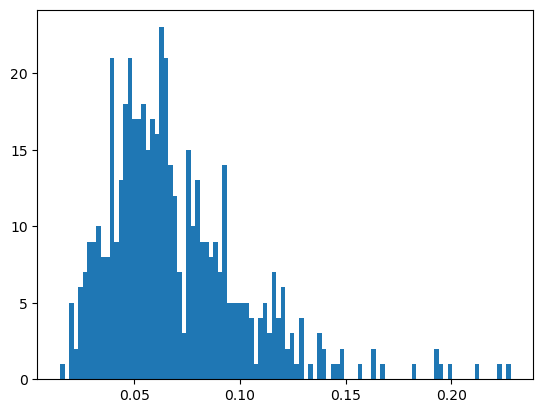

In [313]:
plt.hist(mi,100)
#plt.plot([0.01,0.01#],[0,100])

In [322]:
plot_per_label_acts(label_name,epoch,mask = mask)
plt.savefig(f"./figs/{label_name}_{epoch}.png")
plt.clf()
plt.close()

## SAE time


**Definitions of the summary statistics of SAE latents from Lim et al. 2024**

**Sparsity (activated frequency)** represents how frequently this latent is activated. We count the number of images having positive SAE latent activations and divide by the total number of seen images. An SAE latent with a high frequency either represents a common concept or is an uninterpretable (noisy) latent.

**Mean activation value** is computed by averaging the positive activation value among the activated samples. The mean activation value implies the SAE model’s confidence. A latent direction is more likely to represent a meaningful concept if it has a high 
mean activation value.

**Label entropy** measures how many unique labels activate the latent. Precisely, we compute the probability of a label based on its activation value and compute the entropy as
 $$prob_c = \frac{sum_c}{\sum_{c\in C}sum_c},\quad  entropy = − \sum_{c\in C} (prob_c \log prob_c), (2)$$ 
where $sum_c$ is the summed activation values for label c ∈ C. The entropy being equal to zero indicates that all reference images have exactly the same label. Higher entropy indicates that more labels contribute to the latent’s activation.

**Label standard deviation.** In ImageNet, class labels are organized in a hierarchical structure based on WordNet’s semantic relationships [8, 22]. We leverage this label structure and use the label standard deviation of reference images as a clue for the semantic granularity besides the label entropy when exploring the latents.

In [4]:
from src.base_sae import SparseAutoencoder
from src.sae_utils import *

In [60]:
epoch = 2
seed = "_s4"
normalization_on = True
shapes_te_names = np.load(f"./activations/shapes3d_SN{seed}/epoch{epoch}/resnet18_shapes3d_val_names.npy").flatten()
shapes_te_acts = np.load(f"./activations/shapes3d_SN{seed}/epoch{epoch}/resnet18_shapes3d_val.npy")
shapes_tr_names = np.load(f"./activations/shapes3d_SN{seed}/epoch{epoch}/resnet18_shapes3d_train_names.npy").flatten()
shapes_tr_acts = np.load(f"./activations/shapes3d_SN{seed}/epoch{epoch}/resnet18_shapes3d_train.npy")
shapes_tr_softs = np.load(f"./activations/shapes3d_SN{seed}/epoch{epoch}/resnet18_shapes3d_train_softs.npy")

if normalization_on:
    shapes_tr_acts = feature_normalize(shapes_tr_acts)
    shapes_te_acts = feature_normalize(shapes_te_acts)


tr_labels = split_names_to_dict(shapes_tr_names)
te_labels = split_names_to_dict(shapes_te_names)

latents = torch.tensor(shapes_tr_acts)



Original space nr of concepts:  512.0  and dead: 0.0
object:  2.0 context: 234.0


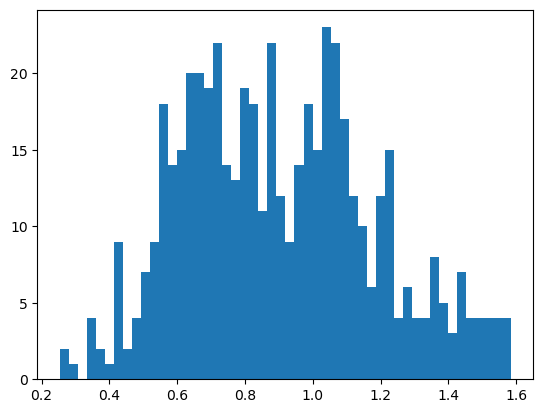

In [172]:
from src.sae_utils import activation_summary_stats
stats = activation_summary_stats(latents, torch.tensor(tr_labels["sh"]), top_k=None)
entropies = [stats[i]["label_entropy"] for i in range(len(stats))]
counts= plt.hist(entropies,50)
print("Original space nr of concepts: ", counts[0].sum()," and dead:",str(latents.size()[1] - counts[0].sum()))
print("object: ", counts[0][0], "context:",str(counts[0][25:].sum()))

In [43]:
import src.base_sae
importlib.reload(src.base_sae)

# Build and train SAE
expansion_coef = 5
input_dim = 512
epochs = 200
batch_size = 512
lr = 1e-3

sae = SparseAutoencoder(input_dim=input_dim, code_dim=input_dim*expansion_coef,tied_weights=False, use_circuits_implementation=True)
train_sae(sae, latents, epochs=epochs, l1_lambda=5e-2,verbose_every=5,lr=lr, batch_size=batch_size)

ckpt_file = Path(f"sae_{seed}_{epoch}_SN_reg{str(normalization_on)}_circuits_non_tied_long_2.pt")
save_checkpoint(sae, ckpt_file, meta={"epochs": epochs})




Epoch   1/200 | loss 0.0001847751  l1 0.0001060431  dead% 26.64  dup_pairs 0  dup_ratio 0.0000  |offdiag| 0.0725 L0 154.259
Epoch   5/200 | loss 0.0000197223  l1 0.0000112107  dead% 97.81  dup_pairs 9  dup_ratio 0.0000  |offdiag| 0.0721 L0 12.003
Epoch  10/200 | loss 0.0000135593  l1 0.0000074803  dead% 98.16  dup_pairs 6  dup_ratio 0.0000  |offdiag| 0.0719 L0 11.574
Epoch  15/200 | loss 0.0000113600  l1 0.0000060798  dead% 98.28  dup_pairs 4  dup_ratio 0.0000  |offdiag| 0.0717 L0 12.126
Epoch  20/200 | loss 0.0000101221  l1 0.0000052816  dead% 98.36  dup_pairs 4  dup_ratio 0.0000  |offdiag| 0.0716 L0 12.612
Epoch  25/200 | loss 0.0000094028  l1 0.0000047318  dead% 98.36  dup_pairs 4  dup_ratio 0.0000  |offdiag| 0.0715 L0 12.868
Epoch  30/200 | loss 0.0000087835  l1 0.0000043500  dead% 98.36  dup_pairs 4  dup_ratio 0.0000  |offdiag| 0.0715 L0 13.294
Epoch  35/200 | loss 0.0000083402  l1 0.0000040572  dead% 98.36  dup_pairs 3  dup_ratio 0.0000  |offdiag| 0.0714 L0 13.764
Epoch  40/200 |

### Mari-Liis

In [71]:
from sklearn.metrics import accuracy_score
train_latents = sae(torch.tensor(shapes_tr_acts))[1].detach().numpy()
y_pred_tr = nn.functional.softmax(torch.tensor(shapes_tr_softs)).argmax(1)

In [128]:
from sklearn.metrics import accuracy_score
train_latents = shapes_tr_acts
y_pred_tr = nn.functional.softmax(torch.tensor(shapes_tr_softs)).argmax(1)

In [129]:
N, C = train_latents.shape
y_tr = np.array(tr_labels["sh"])
threshold = 0.001

heat_map_matric = []
row_names = []
col_names = ["N","Acc"]
for lab in ["fh","wh","oh","sc","sh","or"]:
    a = np.arange(np.array(tr_labels[lab]).max()+1)
    b= [ lab + str(ai)  for ai in a]
    col_names.extend(b)

for i, cid in enumerate(range(C)):
    row = []
    z = train_latents[:, cid]
    active_mask = z > threshold
    if sum(active_mask) == 0:
        continue
    row_names.append(str(cid))
    row.append(np.mean(active_mask))
    pos_acts = z[active_mask]
    acc = accuracy_score(y_tr[active_mask],y_pred_tr[active_mask])
    row.append(acc)
    # Label distribution -------------------------------------------------------
    fhs = np.bincount(np.array(tr_labels["fh"])[active_mask],minlength=5)/sum(active_mask)
    whs = np.bincount(np.array(tr_labels["wh"])[active_mask],minlength=10)/sum(active_mask)
    ohs = np.bincount(np.array(tr_labels["oh"])[active_mask],minlength=10)/sum(active_mask)
    scs = np.bincount(np.array(tr_labels["sc"])[active_mask],minlength=8)/sum(active_mask)
    shs = np.bincount(np.array(tr_labels["sh"])[active_mask],minlength=3)/sum(active_mask)
    ors = np.bincount(np.array(tr_labels["or"])[active_mask],minlength=15)/sum(active_mask)
    row.extend(fhs)
    row.extend(whs)
    row.extend(ohs)
    row.extend(scs)
    row.extend(shs)
    row.extend(ors)
    heat_map_matric.append(row)



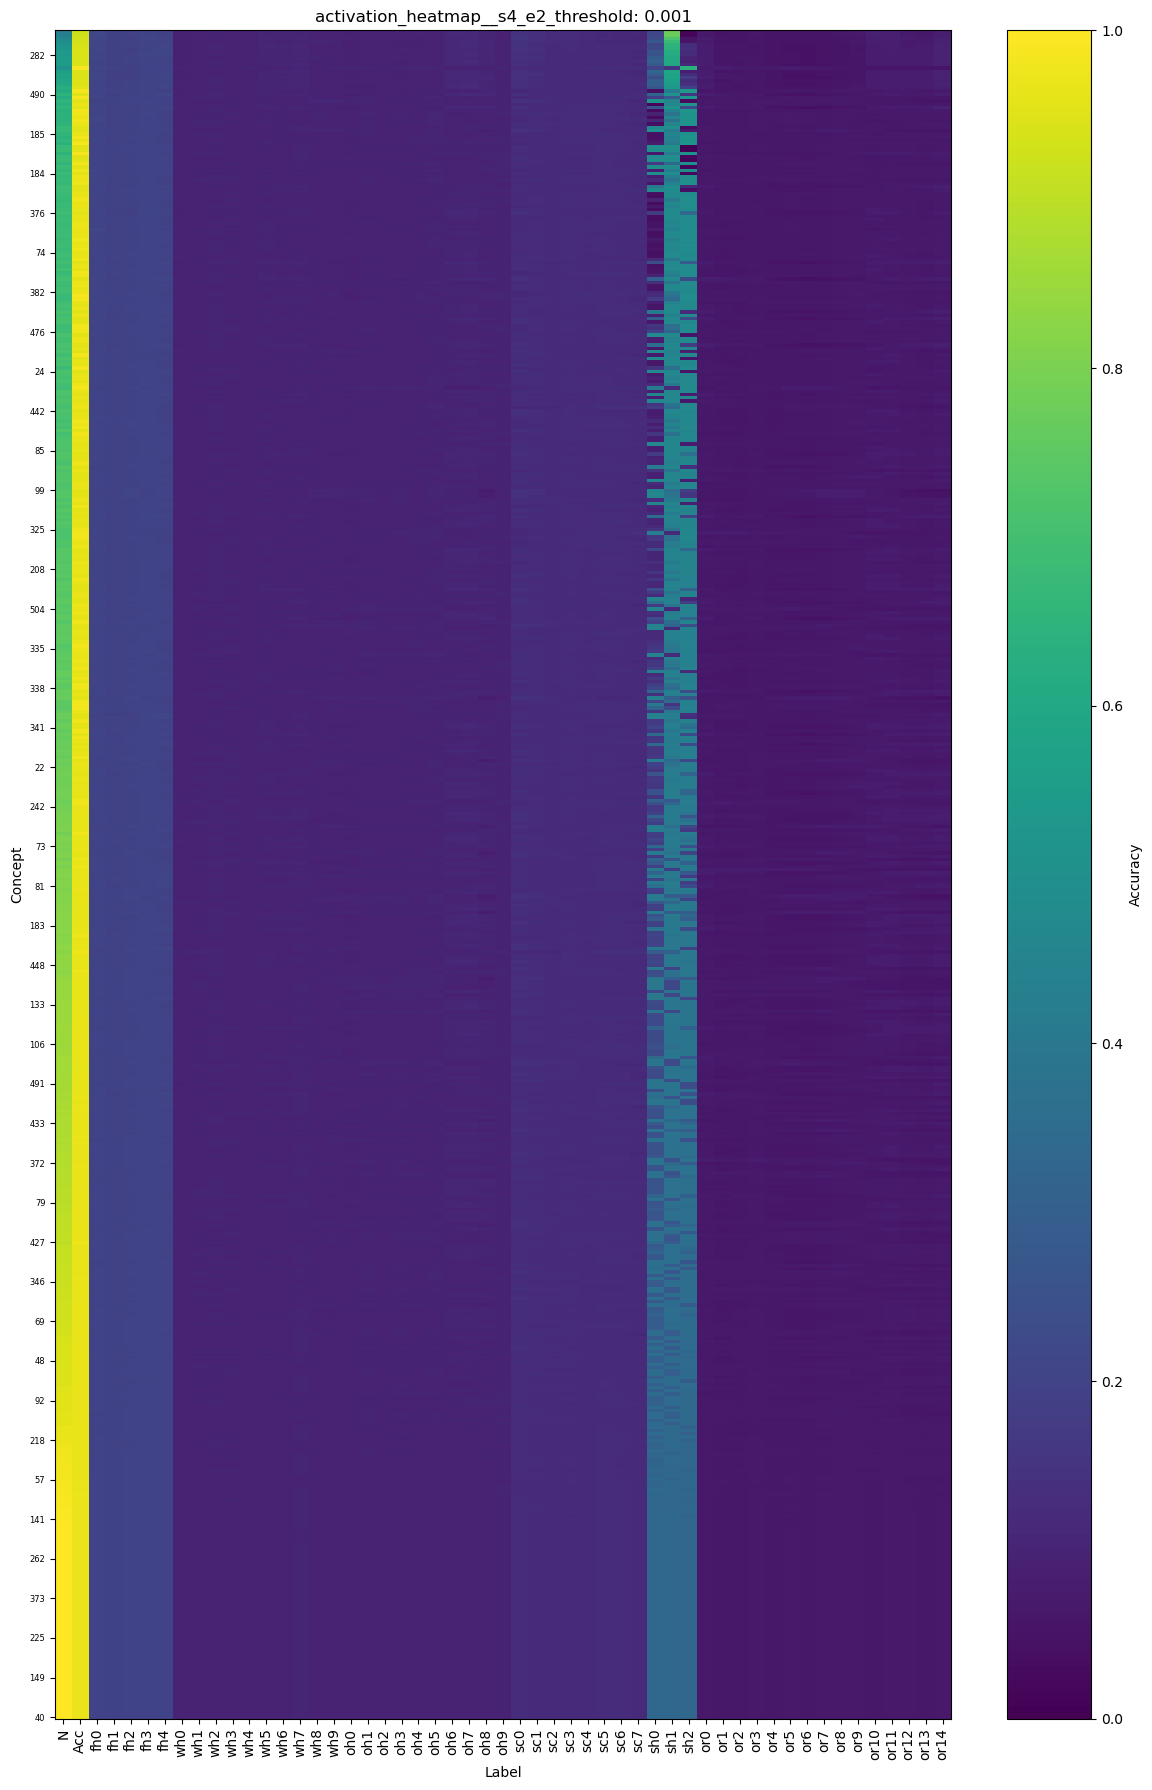

In [130]:
import numpy as np
import matplotlib.pyplot as plt

def plot_concept_label_heatmap(
    acc_matrix,
    concept_names=None,
    label_names=None,
    sort_rows_by_mean=False,
    sort_cols_by_mean=False,
    vmin=0.0,
    vmax=1.0,
    threshold = 0
):
    """
    Plot a heatmap of concept × label accuracies.

    Parameters
    ----------
    acc_matrix : array-like of shape (n_concepts, n_labels)
        Accuracy (or any scalar metric) per concept/label pair.
    concept_names : list of str or None
        Names for concepts (rows). Length = n_concepts.
    label_names : list of str or None
        Names for labels (columns). Length = n_labels.
    sort_rows_by_mean : bool
        If True, sort concepts by descending row-mean.
    sort_cols_by_mean : bool
        If True, sort labels by descending column-mean.
    vmin, vmax : float
        Color scale limits (e.g. 0–1 for accuracy).
    """
    acc = np.asarray(acc_matrix)
    n_concepts, n_labels = acc.shape

    # ---- Sorting ----
    row_order = np.arange(n_concepts)
    col_order = np.arange(n_labels)

    if sort_rows_by_mean:
        row_order = np.argsort(-acc.mean(axis=1))  # descending
    if sort_cols_by_mean:
        col_order = np.argsort(-acc.mean(axis=0))  # descending

    acc_sorted = acc[row_order][:, col_order]

    if concept_names is not None:
        concept_names = [concept_names[i] for i in row_order]
    if label_names is not None:
        label_names = [label_names[j] for j in col_order]

    # ---- Figure size heuristic ----
    # Scale width with number of labels, height with number of concepts
    fig_width = min(16, 4 + 0.15 * n_labels)
    fig_height = min(18, 4 + 0.08 * n_concepts)

    fig, ax = plt.subplots(figsize=(fig_width, fig_height))

    im = ax.imshow(
        acc_sorted,
        aspect='auto',
        origin='lower',
        vmin=vmin,
        vmax=vmax
    )

    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("Accuracy")

    ax.set_xlabel("Label")
    ax.set_ylabel("Concept")

    # ---- X-axis labels ----
    ax.tick_params(axis='y', labelsize=6)  # or 4, 8, etc.

    if label_names is not None:
        ax.set_xticks(np.arange(n_labels))
        ax.set_xticklabels(label_names, rotation=90)
    else:
        ax.set_xticks([])

    # ---- Y-axis labels ----
    if concept_names is not None and n_concepts <= 300:
        # Only label all concepts if there aren't too many
        ax.set_yticks(np.arange(n_concepts))
        ax.set_yticklabels(concept_names)
    elif concept_names is not None:
        # For many concepts, only label every Nth
        step = max(1, n_concepts // 40)
        tick_positions = np.arange(0, n_concepts, step)
        tick_labels = [concept_names[i] for i in tick_positions]
        ax.set_yticks(tick_positions)
        ax.set_yticklabels(tick_labels)
    else:
        ax.set_yticks([])
    plt.title(f"activation_heatmap_{seed}_e{epoch}_threshold: {threshold}")
    plt.tight_layout()
    plt.savefig(f"./heatmap_{seed}_e{epoch}_thr{threshold}.png")
    plt.show()


plot_concept_label_heatmap(heat_map_matric,label_names=col_names,concept_names=row_names, sort_rows_by_mean=True,threshold=threshold)

In [44]:
torch.sum(sae.decoder.weight**2,1)

tensor([ 4.7784,  2.3694,  1.8911, 11.0270,  2.3772,  1.8360,  4.3737,  2.1511,
         2.9732,  4.3560,  2.7129,  2.5030,  7.2085,  3.9669,  2.6604, 10.7372,
         3.6137,  8.3662,  3.8908,  2.9882,  4.6187,  5.1672,  3.8193,  1.3095,
         8.8741,  6.6607,  1.5536, 16.5863,  1.2073,  7.2840,  2.1813, 14.6294,
         7.1975,  3.9562,  3.8514,  5.5823,  2.3523,  2.5147,  3.1001,  5.4045,
         6.3432,  4.5014,  3.2850,  1.5971,  2.4933,  4.3047,  1.2507,  8.8254,
         2.4983,  2.3214,  8.5800,  2.2878,  3.7346,  6.6004, 14.8024,  3.7420,
        13.2145,  2.9946,  8.7991,  1.1619,  5.0681,  2.4667,  2.1047,  2.4652,
         4.4663,  2.7579,  2.1218,  6.6626,  3.5679,  2.1218,  9.7391,  8.0652,
         2.9334,  3.3683,  1.5157,  2.9261,  2.3380,  5.6520,  7.1029,  2.6257,
         3.3844,  3.4095,  6.7186,  4.5601,  5.6500,  1.1349,  5.0874,  9.3789,
         2.0519,  1.8283,  1.8633, 10.4715,  3.4225,  2.7517,  4.0984,  5.6599,
         5.4102,  2.8157,  2.9620, 13.27

In [57]:
import src.base_sae


importlib.reload(src.sae_utils)
importlib.reload(src.base_sae)
# Save a checkpoint
ckpt_file = Path(f"./sae_{seed}_{epoch}_SN_reg{str(normalization_on)}_circuits_non_tied.pt")
# Reload model
sae = load_checkpoint(ckpt_file)

# Grab top activations for concept 13


concepts:  204.0 dead: 2356.0
object:  54.0 context: 91.0


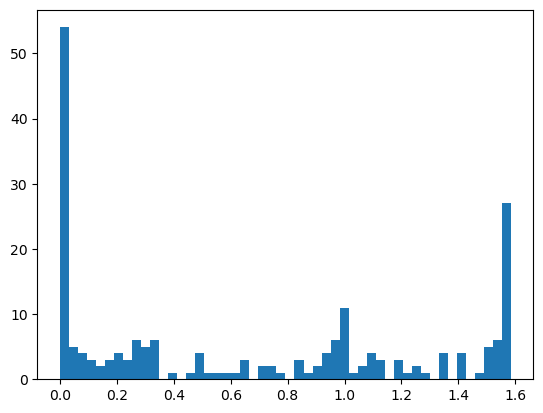

In [58]:
stats = concept_summary_stats(sae, latents, torch.tensor(tr_labels["sh"]), top_k=None)
entropies = [stats[i]["label_entropy"] for i in range(len(stats))]
counts= plt.hist(entropies,50)
print("concepts: ", counts[0].sum(),"dead:",str(latents.size()[1]*5- counts[0].sum()))
print("object: ", counts[0][0], "context:",str(counts[0][25:].sum()))



In [46]:
stats

{0: {'sparsity': 0.0,
  'mean_activation': 0.0,
  'label_entropy': nan,
  'label_std': nan},
 1: {'sparsity': 0.0,
  'mean_activation': 0.0,
  'label_entropy': nan,
  'label_std': nan},
 2: {'sparsity': 0.0,
  'mean_activation': 0.0,
  'label_entropy': nan,
  'label_std': nan},
 3: {'sparsity': 0.0,
  'mean_activation': 0.0,
  'label_entropy': nan,
  'label_std': nan},
 4: {'sparsity': 0.0,
  'mean_activation': 0.0,
  'label_entropy': nan,
  'label_std': nan},
 5: {'sparsity': 0.0,
  'mean_activation': 0.0,
  'label_entropy': nan,
  'label_std': nan},
 6: {'sparsity': 0.0,
  'mean_activation': 0.0,
  'label_entropy': nan,
  'label_std': nan},
 7: {'sparsity': 0.0,
  'mean_activation': 0.0,
  'label_entropy': nan,
  'label_std': nan},
 8: {'sparsity': 0.0,
  'mean_activation': 0.0,
  'label_entropy': nan,
  'label_std': nan},
 9: {'sparsity': 0.0,
  'mean_activation': 0.0,
  'label_entropy': nan,
  'label_std': nan},
 10: {'sparsity': 0.0,
  'mean_activation': 0.0,
  'label_entropy': na

In [47]:

most_specific = rank_concepts(stats, key="label_entropy", ascending=False, top_n=30, return_scores=True)
print("Top 10 most label‑diverse concepts (high entropy):")
for cid, sc in most_specific:
    print(f"  Concept {cid:4d} | entropy = {sc:.3f}")
most_common= rank_concepts(stats, key="sparsity", ascending=False, top_n=10, return_scores=True)
print("Top 10 most common concepts (high sparsity):")
for cid, sc in most_common:
    print(f"  Concept {cid:4d} | sparsity = {sc:.3f}")
most_common= rank_concepts(stats, key="mean_activation", ascending=False, top_n=10, return_scores=True)
print("Top 10 most common concepts (high activation):")
for cid, sc in most_common:
    print(f"  Concept {cid:4d} | mean_activation = {sc:.3f}")
most_common= rank_concepts(stats, key="label_std", ascending=False, top_n=10, return_scores=True)
print("Top 10 most common concepts (high label_std):")
for cid, sc in most_common:
    print(f"  Concept {cid:4d} | std = {sc:.3f}")

Top 10 most label‑diverse concepts (high entropy):
  Concept 2382 | entropy = 1.255
  Concept 2111 | entropy = 1.122
  Concept 1263 | entropy = 1.036
  Concept 2047 | entropy = 0.999
  Concept 2144 | entropy = 0.981
  Concept 1581 | entropy = 0.969
  Concept 1918 | entropy = 0.941
  Concept 1574 | entropy = 0.927
  Concept  841 | entropy = 0.909
  Concept 2091 | entropy = 0.891
  Concept  109 | entropy = 0.877
  Concept  432 | entropy = 0.868
  Concept 1303 | entropy = 0.860
  Concept  564 | entropy = 0.797
  Concept 1385 | entropy = 0.787
  Concept  583 | entropy = 0.787
  Concept  907 | entropy = 0.775
  Concept  337 | entropy = 0.717
  Concept 2213 | entropy = 0.689
  Concept 1050 | entropy = 0.682
  Concept 1797 | entropy = 0.603
  Concept  641 | entropy = 0.567
  Concept 1017 | entropy = 0.547
  Concept 1348 | entropy = 0.546
  Concept  899 | entropy = 0.469
  Concept 2326 | entropy = 0.429
  Concept  250 | entropy = 0.407
  Concept 2486 | entropy = 0.293
  Concept 1414 | entropy 

In [48]:
criteria = {
    "sparsity":        (1e-2, None),   # upper-bounded
    "label_entropy":   (None,None),    # upper-bounded
    "mean_activation": (1e-2, None ),   # lower-bounded
    "label_std" : (None,None)
}


picked = query_concepts(stats,
                        bounds=criteria,
                        sort_key="label_entropy",  # any metric in the dict
                        ascending=True,            # smallest entropy first
                        return_scores=True)        # → [(id, metric_dict), …]


In [49]:
picked_keys= [i[0] for i in picked]
picked_keys

[1224, 2093, 1554, 512, 109]

In [51]:
stats[picked_keys[-1]]

{'sparsity': 0.6104,
 'mean_activation': 0.010576645843684673,
 'label_entropy': 0.8767331575684258,
 'label_std': 0.5487300157546997}

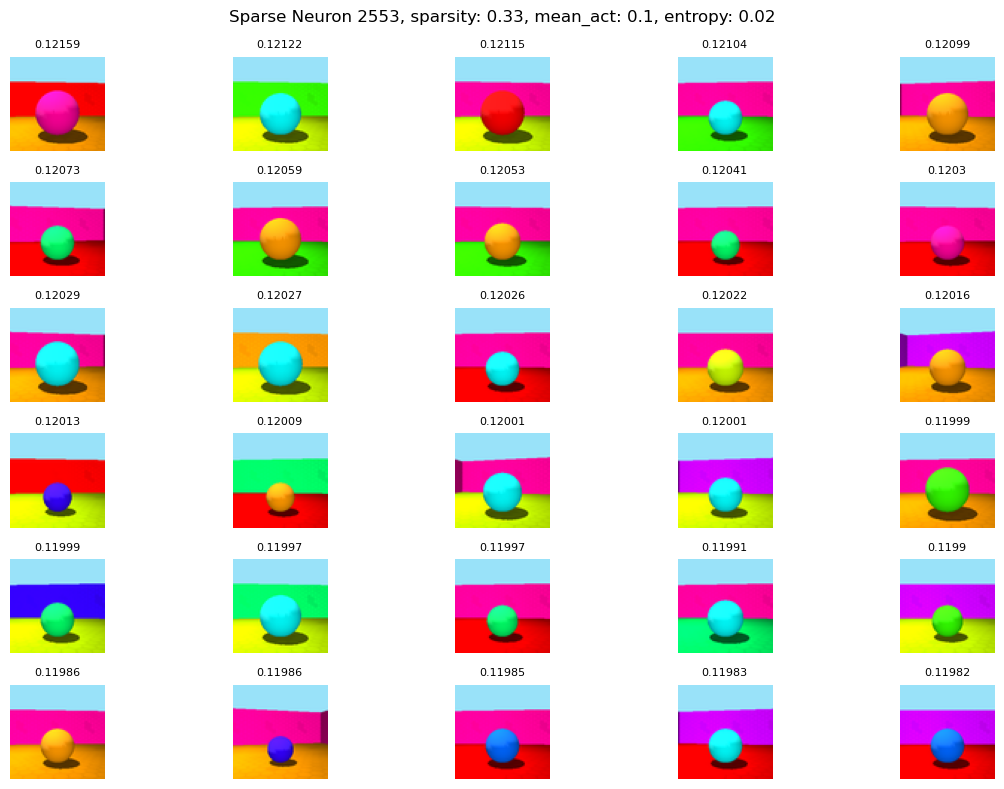

In [138]:
concept = 2553#picked_keys[-1]
top_idx, top_act = most_activated_indices(sae, latents, concept, k=30)

plot_top_k_images(shapes_tr_names[top_idx],data,figsize=(12,8),top_act = top_act.detach().numpy(),stats=stats[concept],neuron_nr=concept)

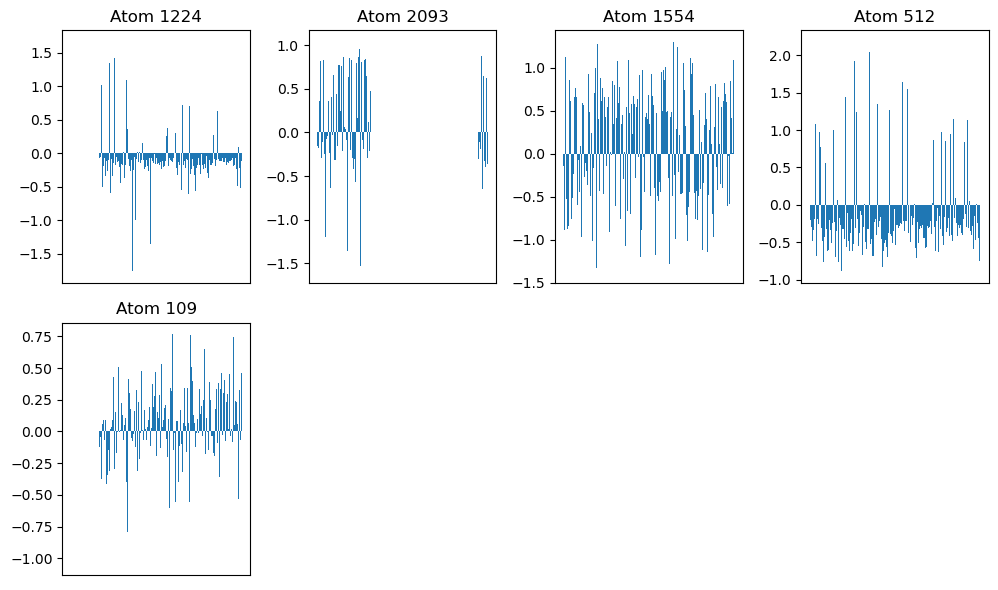

In [54]:
# Visualise dictionary atoms & top images 
atom_indexes = picked_keys[-7:]
plot_dictionary_atoms(sae, num_atoms=len(atom_indexes),atom_indexes_bool=True,atom_indexes=atom_indexes)



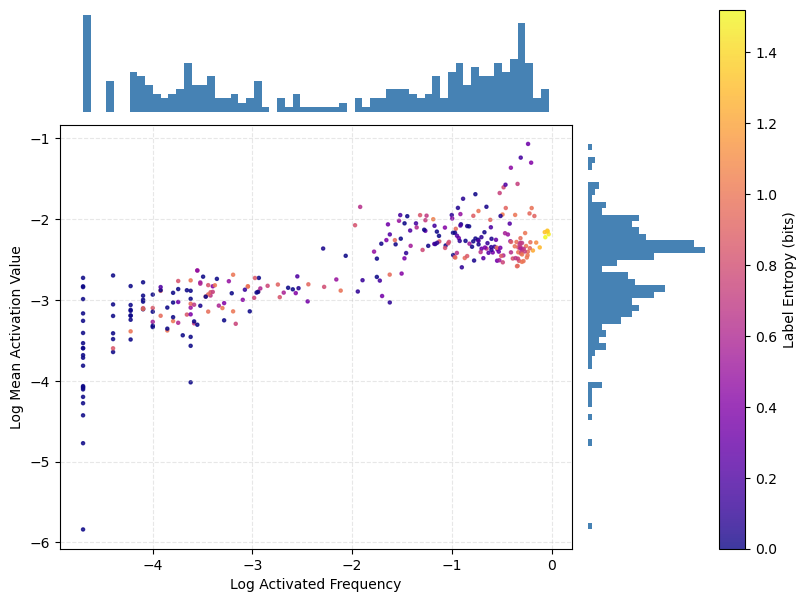

In [28]:
plot_metrics_figure(stats)

### Feature viz

In [131]:
import torch
import torch.nn.functional as F
from torch import nn
from contextlib import contextmanager
from openood.networks.resnet18_32x32 import ResNet18_32x32
from torch.nn.utils import spectral_norm
import torchvision.transforms as tvs_trans

# -----------------------------
# Utilities
# -----------------------------
IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1)
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1)

SHAPES_MEAN = torch.tensor([0.502787, 0.57902, 0.603774]).view(1,3,1,1)
SHAPES_STD = torch.tensor([0.342082, 0.39335, 0.413426]).view(1,3,1,1)


@contextmanager
def eval_mode(*models):
    modes = [m.training for m in models]
    for m in models: m.eval()
    try:
        yield
    finally:
        for m, was_train in zip(models, modes):
            m.train(was_train)

def rn18_gap_from_acts(A):  # [B,512,H,W] -> [B,512]
    return A.mean(dim=(2,3))

def get_last_conv_layer(rn18: nn.Module):
    """
    Good Grad-CAM target for ResNet-18 last conv.
    You can also try rn18.layer4[-1].bn2 or rn18.layer4 for slightly different maps.
    """
    return rn18.layer4[-1].conv2

def sae_forward_get_z(sae: nn.Module, gap_512: torch.Tensor):
    _ ,z = sae(gap_512)
    return z  # [B, K]

# -----------------------------
# A1. Grad-CAM for SAE concept k
# -----------------------------
@torch.no_grad()
def _normalize_minmax(x, eps=1e-8):
    x = x - x.min()
    return x / (x.max() + eps)


def gradcam_sae_concept(rn18, sae, x, k: int, target_layer: nn.Module=None):
    """
    Grad-CAM for SAE concept k using a TENSOR gradient hook (no module backward hook).
    Returns heatmap [H,W] in [0,1].
    """
    assert x.ndim == 4 and x.size(0) == 1
    device = next(rn18.parameters()).device
    x = x.to(device).float()
    if x.max() > 1.5:  # allow 0..255 inputs
        x = x / 255.0
    x_norm = (x - SHAPES_MEAN.to(device)) / SHAPES_STD.to(device)

    if target_layer is None:
        target_layer = get_last_conv_layer(rn18)

    # ---- forward hook to capture activations ----
    acts = {}
    def fwd_hook(_, __, out):
        acts['A'] = out  # IMPORTANT: do NOT .detach(), we need the graph
    h = target_layer.register_forward_hook(fwd_hook)

    rn18.eval(); sae.eval()
    rn18.zero_grad(set_to_none=True)
    sae.zero_grad(set_to_none=True)

    # Forward once to populate acts['A']
    _ = rn18(x_norm)                      # logits ignored; we use acts['A']
    A = acts['A']                         # [1,512,H,W]
    h.remove()                            # forward hook no longer needed

    # ---- attach a gradient hook to the TENSOR itself ----
    grads = {}
    A.retain_grad()
    def tensor_grad_hook(g):
        grads['dA'] = g
    A.register_hook(tensor_grad_hook)

    # Build the scalar target from A -> GAP -> SAE so the graph goes through A
    gap = rn18_gap_from_acts(A)           # [1,512]
    z = sae_forward_get_z(sae, gap)       # [1,K]
    y = z[:, k].sum()

    # Backprop; no retain_graph needed
    y.backward()

    # Compute CAM
    A = A[0]                              # [512,H,W]
    dA = grads['dA'][0]                   # [512,H,W]
    alpha = dA.mean(dim=(1,2), keepdim=True)   # [512,1,1]
    cam = torch.relu((alpha * A).sum(dim=0))   # [H,W]
    cam = _normalize_minmax(cam)
    return cam

# Activation Maximization for z_k
# -----------------------------

def total_variation(x, eps=1e-8):
    dh = x[:, :, 1:, :] - x[:, :, :-1, :]
    dw = x[:, :, :, 1:] - x[:, :, :, :-1]
    return (dh.pow(2).mean() + dw.pow(2).mean() + eps).sqrt()


def activation_maximize_concept(rn18: nn.Module,
                                sae: nn.Module,
                                k: int,
                                image_size=(224,224),
                                steps=300,
                                lr=0.1,
                                tv_weight=2e-3,
                                l2_weight=1e-4,
                                jitter=8,
                                blur_every=0,
                                seed: int | None = 0,
                                device: torch.device | None = None):
    if device is None:
        device = next(rn18.parameters()).device
    H, W = image_size

    if seed is not None:
        torch.manual_seed(seed)

    rn18.eval()
    sae.eval()

    # Do not store grads in rn18 / sae params
    for p_param in rn18.parameters():
        p_param.requires_grad_(False)
    for p_param in sae.parameters():
        p_param.requires_grad_(False)

    # Optional: get layer + hook once
    acts = {}
    layer = get_last_conv_layer(rn18)
    handle = layer.register_forward_hook(lambda m, i, o: acts.setdefault("A", o))

    p = torch.zeros(1, 3, H, W, device=device, requires_grad=True)
    opt = torch.optim.Adam([p], lr=lr)

    def p_to_img(p):
        x = torch.tanh(p) * 0.5 + 0.5
        return x.clamp(0, 1)

    trace = []

    try:
        for t in range(1, steps + 1):
            opt.zero_grad(set_to_none=True)

            x = p_to_img(p)
            assert torch.isfinite(x).all(), "x non-finite before normalization"
            if jitter > 0:
                ox = torch.randint(-jitter, jitter + 1, (1,), device=device).item()
                oy = torch.randint(-jitter, jitter + 1, (1,), device=device).item()
                x = torch.roll(x, shifts=(ox, oy), dims=(2, 3))

            x_norm = (x - SHAPES_MEAN.to(device)) / SHAPES_STD.to(device)

            acts.clear()
            _ = rn18(x_norm)
            A = acts["A"]
            assert torch.isfinite(A).all(), "A non-finite"

            gap = rn18_gap_from_acts(A)
            assert torch.isfinite(gap).all(), "gap non-finite"

            z = sae_forward_get_z(sae, gap)  # [1, K]
            assert torch.isfinite(z).all(), "z non-finite"

            zk = z[:, k].mean()

            tv = total_variation(x)
            l2 = (x ** 2).mean()

            loss = -zk + tv_weight * tv + l2_weight * l2
            #loss = -zk
            loss.backward()
            torch.nn.utils.clip_grad_norm_([p], max_norm=10.0)

            #print("p.grad mean:", p.grad.abs().mean().item())
            opt.step()
            with torch.no_grad():
                p.clamp_(-5.0, 5.0)

            trace.append(float(zk.detach().cpu()))
    finally:
        handle.remove()

    img = p_to_img(p).detach().cpu()
    return {"img": img, "trace": trace}


def add_spectral_norm(module: nn.Module):
    for name, child in list(module.named_children()):
        add_spectral_norm(child)
        if isinstance(child, (nn.Conv2d, nn.Linear)):
            setattr(module, name, spectral_norm(child))  # n_power_iterations=1 by default
    return module

# -----------------------------
# Example usage (pseudo)
# -----------------------------
net = ResNet18_32x32(num_classes=3)
#net = ResNet18_224x224(num_classes=num_classes)
net = add_spectral_norm(net)
net.load_state_dict(
    torch.load("openood\shapes3d_resnet18_32x32_SN_base_e5_lr0.1_default\s4\model_epoch1.ckpt",map_location="cpu")
)
rn18 = net

device = next(rn18.parameters()).device

# 1) Grad-CAM for concept k
x = torch.tensor(data[0]).permute(2,0,1)
pre_size = 32
x = tvs_trans.Resize(pre_size, interpolation=tvs_trans.InterpolationMode.BILINEAR)(x)
k = picked_keys[-1]
cam_grad = gradcam_sae_concept(rn18, sae, x.reshape(1,3,32,32), k)  # [H,W] in 0..1

# 2) Weight-CAM for concept k
#cam_w = weightcam_sae_concept(rn18, sae, x, k, keep_top=64, zscore_weights=True)  # [H,W]

# 3) Activation maximization image for concept k
#synth = activation_maximize_concept(rn18, sae, k, image_size=(224,224), steps=300, lr=0.1)
#x_synth = synth['img']   # [1,3,H,W] in [0,1]
#trace = synth['trace']   # list of z_k values over iterations


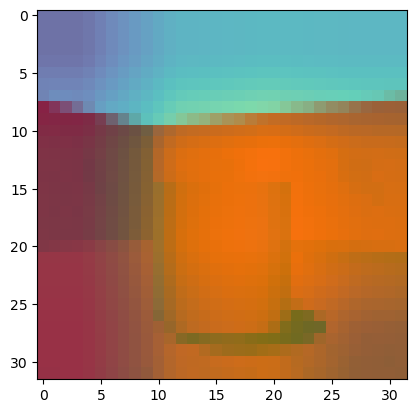

In [135]:

x = torch.tensor(data[329]).permute(2,0,1)
pre_size = 32
x = tvs_trans.Resize(pre_size, interpolation=tvs_trans.InterpolationMode.BILINEAR)(x)
k = 2553#picked_keys[-7]
cam_grad = gradcam_sae_concept(rn18, sae, x.reshape(1,3,32,32), k)  # [H,W] in 0..1
cam_up = F.interpolate(cam_grad[None,None], size=x.shape[-2:], mode="bilinear", align_corners=False)[0,0]


plt.imshow(x.permute(1,2,0))
plt.imshow(cam_up,alpha = 0.5)

In [143]:
# 3) Activation maximization image for concept k
k = 2553#picked_keys[-9]

synth = activation_maximize_concept(rn18, sae, k, image_size=(32,32), steps=100, lr=0.05,tv_weight=1e-3,l2_weight=1e-4)
x_synth = synth['img']   # [1,3,H,W] in [0,1]
trace = synth['trace']   # list of z_k values over iterations

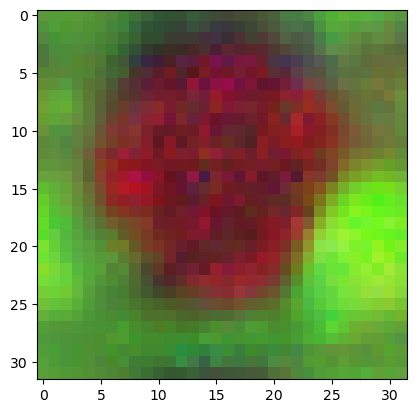

In [144]:
plt.imshow(x_synth[0].permute(1,2,0))

In [200]:
x = torch.tensor(data[30]).permute(2,0,1)
pre_size = 32
x = tvs_trans.Resize(pre_size, interpolation=tvs_trans.InterpolationMode.BILINEAR)(x)
k = picked_keys[-400]
cam_grad = gradcam_sae_concept(rn18, sae, x.reshape(1,3,32,32), k)  # [H,W] in 0..1
cam_up = F.interpolate(cam_grad[None,None], size=x.shape[-2:], mode="bilinear", align_corners=False)[0,0]


plt.imshow(x.permute(1,2,0))
plt.imshow(cam_up,alpha = 0.5)

RuntimeError: can't retain_grad on Tensor that has requires_grad=False

In [192]:
criteria_obj = {
    "sparsity":        (None, None),   # upper-bounded
    "label_entropy":   (None,0.2),    # upper-bounded
    "mean_activation": (None,None ),   # lower-bounded
    "label_std" : (None,None)
}

criteria_ctx = {
    "sparsity":        (None,None),   # upper-bounded
    "label_entropy":   (0.8,None),    # upper-bounded
    "mean_activation": (None, None ),   # lower-bounded
    "label_std" : (None,None)
}
picked_obj = query_concepts(stats,
                        bounds=criteria_obj,
                        sort_key="label_entropy",  # any metric in the dict
                        ascending=True,            # smallest entropy first
                        return_scores=True)        # → [(id, metric_dict), …]
picked_ctx = query_concepts(stats,
                        bounds=criteria_ctx,
                        sort_key="label_entropy",  # any metric in the dict
                        ascending=True,            # smallest entropy first
                        return_scores=True)        # → [(id, metric_dict), …]




In [193]:
picked_obj= [i[0] for i in picked_obj]
picked_ctx =  [i[0] for i in picked_ctx]


In [194]:
len(picked_ctx), len(picked_obj)

(153, 12)

#### Lets try out the covariate and semantic shift detection using dedicated neuron masks

In [195]:
# ---------- Mahalanobis (class-conditional) ----------
from sklearn.covariance import LedoitWolf

def fit_mahalanobis(feats_train: np.ndarray, y_train: np.ndarray, cov: str="tied_diag") -> Dict[str, np.ndarray]:
    """
    Fit class means and covariance model.
    cov ∈ {"tied_diag", "tied_full", "tied_shrink"}:
      - tied_diag: diagonal covariance pooled over all classes (fast, robust)
      - tied_full: full covariance pooled over all classes (needs enough data)
      - tied_shrink: Ledoit-Wolf shrinkage estimator (recommended if D large)
    """
    C = int(y_train.max()) + 1
    D = feats_train.shape[1]
    mus = np.stack([feats_train[y_train == c].mean(axis=0) for c in range(C)], axis=0)  # [C,D]

    Xc = feats_train - mus[y_train]
    if cov == "tied_diag":
        var = Xc.var(axis=0, unbiased=True) + 1e-6
        return {"type": "diag", "mus": mus, "inv_var": 1.0 / var}
    elif cov == "tied_full":
        Sigma = np.cov(Xc.T, ddof=1) + 1e-6 * np.eye(D)
        Sigma_inv = np.linalg.inv(Sigma)
        return {"type": "full", "mus": mus, "Sigma_inv": Sigma_inv}
    elif cov == "tied_shrink":
        lw = LedoitWolf().fit(Xc)
        Sigma_inv = np.linalg.inv(lw.covariance_)
        return {"type": "full", "mus": mus, "Sigma_inv": Sigma_inv}
    else:
        raise ValueError("Unknown cov: %s" % cov)

def maha_score(params: Dict[str, np.ndarray], feats: np.ndarray) -> np.ndarray:
    """
    Return the *distance* to the nearest class mean.
    Lower distance ⇒ more InD. For OOD scoring, set higher_is_ood=True (we'll flip sign).
    """
    mus = params["mus"]  # [C,D]
    F = feats[:, None, :] - mus[None, :, :]  # [N,C,D]
    if params["type"] == "diag":
        inv_var = params["inv_var"]  # [D]
        d2 = (F**2 * inv_var[None, None, :]).sum(axis=2)  # [N,C]
    else:
        # full
        Sinv = params["Sigma_inv"]  # [D,D]
        # compute quadratic form: for each (n,c), f^T Sinv f
        # reshape to [N*C, D]
        FC = F.reshape(-1, F.shape[-1])  # [N*C, D]
        Q = FC @ Sinv
        d2 = (Q * FC).sum(axis=1).reshape(F.shape[0], F.shape[1])
    return d2.min(axis=1)  # [N]



In [272]:
test_latents = sae(torch.tensor(shapes_te_acts))[1].detach().numpy()
train_latents = sae(torch.tensor(shapes_tr_acts))[1].detach().numpy()




In [197]:
N, C = train_latents.shape
labels = np.array(tr_labels["sh"])
label_max = [sum(labels == 0),sum(labels==1),sum(labels==2)]
print(label_max)
cl2_mask_count = []
cl1_mask_count = []
cl3_mask_count = []
rest_mask_count = []
for i, cid in enumerate(range(C)):
    if math.isnan(stats[i]["label_entropy"]):
        cl1_mask_count.append(False)
        cl2_mask_count.append(False)
        cl3_mask_count.append(False)
        rest_mask_count.append(False)
        continue
    z = train_latents[:, cid]
    threshold = 0
    active_mask = z > threshold
    pos_acts = z[active_mask]

    # Label entropy -------------------------------------------------------
    lbl_subset = labels[active_mask]
    lbl_dist = np.array([sum(lbl_subset == 0),sum(lbl_subset==1),sum(lbl_subset==2)])
    lbl_dist_normed = lbl_dist/len(lbl_subset)
    print(lbl_dist, lbl_dist_normed,stats[i]["label_entropy"], lbl_dist_normed.max() > 0.85,sum(lbl_dist_normed > 0.3) ==3)
    cl1_mask_count.append(lbl_dist_normed.max() > 0.95)
    cl3_mask_count.append(sum(lbl_dist_normed > 0.3) ==3)
    cl2_mask_count.append(sum(lbl_dist_normed > 0.3) ==2)
    rest_mask_count.append(~cl1_mask_count[i]*sum(lbl_dist_normed > 0.3) ==1)



[16814, 16684, 16502]
[745 751 861] [0.31607976 0.31862537 0.36529487] 1.578189164614115 False True
[0 4 1] [0.  0.8 0.2] 0.8445018029789015 False False
[5650 5981 4983] [0.34007464 0.35999759 0.29992777] 1.5622250470304258 False False
[9798 9855 9642] [0.33445981 0.33640553 0.32913466] 1.5832955015008827 False True
[5014 4546 4496] [0.35671599 0.3234206  0.3198634 ] 1.5825246752597157 False True
[9414 8927 8436] [0.35157038 0.33338313 0.3150465 ] 1.5833785691212496 False True
[ 9788  9832 10168] [0.32858869 0.3300658  0.34134551] 1.5829424211186616 False True
[12  3  2] [0.70588235 0.17647059 0.11764706] 0.5632615837193407 False False
[ 9400 10085  9671] [0.32240362 0.34589793 0.33169845] 1.582348737007883 False True
[1 0 0] [1. 0. 0.] -0.0 True False
[1428 1467 1017] [0.36503067 0.375      0.25996933] 1.5486662788017036 False False
[8698 8935 8750] [0.32968199 0.33866505 0.33165296] 1.584892188431493 False True
[ 92  50 100] [0.38016529 0.20661157 0.41322314] 1.5488974234844632 False

In [198]:
sum(cl1_mask_count), sum(cl2_mask_count),sum(cl3_mask_count),sum(rest_mask_count)

(20, 73, 74, 16)

In [199]:
ood_fh_mask = (np.array(te_labels["fh"]) > 4)
ood_shape_mask = (np.array(te_labels["sh"]) == 3)
test_mask = ~ood_fh_mask*~ood_shape_mask
ood_fh = test_latents[ood_fh_mask]
ood_shape = test_latents[ood_shape_mask]
test = test_latents[test_mask]

In [269]:
entropies = np.array([stats[i]["label_entropy"] for i in range(len(stats))])
nan_mask = np.array([math.isnan(entropies[i]) for i in range(len(entropies)) ])
mask_0 = np.array(entropies) == 0
#mask_1 = (np.array(entropies) <=1)*~nan_mask*~mask_0
mask_object = np.array(entropies) < 5*(entropies[~nan_mask].max()/100)
mask_context = (np.array(entropies) >= (90* entropies[~nan_mask].max()/100))
mask_rest = ~mask_context*~mask_object*~nan_mask


In [270]:
mask_object.sum(),mask_context.sum(), mask_rest.sum()

(20, 129, 34)

#### Lets check the coverage 


In [202]:
perc_obj_coverage = 1- (train_latents.T[mask_object].T.sum(1) == 0).sum()/len(train_latents)
perc_ctx_coverage = 1- (train_latents.T[mask_context].T.sum(1) == 0).sum()/len(train_latents)
perc_nan_coverage = 1- (train_latents.T[nan_mask].T.sum(1) == 0).sum()/len(train_latents)


print("perc obj mask coverage:", perc_obj_coverage)
print("perc ctx mask coverage:", perc_ctx_coverage)
print("perc nan mask coverage:", perc_nan_coverage)




perc obj mask coverage: 0.0009000000000000119
perc ctx mask coverage: 1.0
perc nan mask coverage: 0.0


In [252]:
train_acts_normed_tensor = torch.tensor(train_latents)
mahal_params = fit_mahalanobis(train_acts_normed_tensor,np.array(tr_labels["sh"]),"tied_diag")
maha_test = maha_score(mahal_params,torch.tensor(test))[0]
maha_obj = maha_score(mahal_params,torch.tensor(ood_shape))[0]
maha_ctx = maha_score(mahal_params,torch.tensor(ood_fh))[0]

classes = [0]*len(maha_test) + [1]*(len(maha_ctx)+len(maha_obj))
roc_auc_score(classes, np.concatenate([maha_test,maha_ctx,maha_obj]))

0.46457926977597164

In [253]:
mahal_params = fit_mahalanobis(torch.tensor(train_latents.T[~nan_mask].T),np.array(tr_labels["sh"]),"tied_diag")
maha_test = maha_score(mahal_params,torch.tensor(test.T[~nan_mask].T))[0]
maha_obj = maha_score(mahal_params,torch.tensor(ood_shape.T[~nan_mask].T))[0]
maha_ctx = maha_score(mahal_params,torch.tensor(ood_fh.T[~nan_mask].T))[0]

print("without nans")
classes_obj = [0]*len(maha_test) + [1]*(len(maha_obj))
print(roc_auc_score(classes_obj, np.concatenate([maha_test,maha_obj])))
classes_ctx= [0]*len(maha_test) + [1]*(len(maha_ctx))
print(roc_auc_score(classes_ctx, np.concatenate([maha_test,maha_ctx])))

without nans
0.4486875617934538
0.45574715379904324


In [146]:
mask_context = picked_ctx
mask_object = picked_obj

In [203]:
mask_context = np.array(cl2_mask_count)#+np.array(cl1_mask_count)
mask_object = cl3_mask_count

In [300]:
mask_object = [111,671,1929,2404]
mask_context = [671,1986,2207,1252]

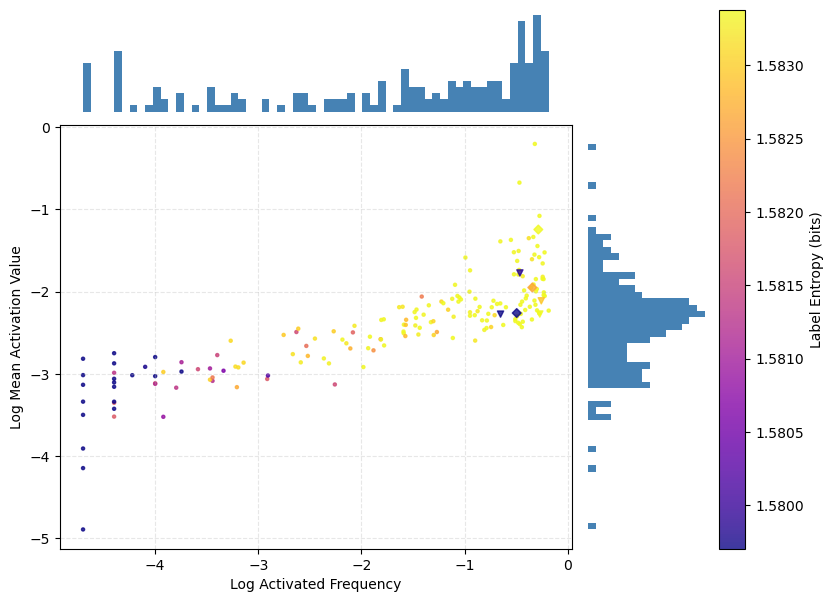

In [301]:
import src.sae_utils


importlib.reload(src.sae_utils)

shapes= ["."]*expansion_coef*512
for i in mask_context:
    shapes[i] = "D"
for i in mask_object:
    shapes[i] = "v"

src.sae_utils.plot_metrics_figure(stats,shapes=shapes)

In [293]:
mahal_params = fit_mahalanobis(torch.tensor(train_latents.T[mask_object].T),np.array(tr_labels["sh"]),"tied_diag")
maha_test = maha_score(mahal_params,torch.tensor(test).T[mask_object].T)[0]
maha_obj = maha_score(mahal_params,torch.tensor(ood_shape).T[mask_object].T)[0]
maha_ctx = maha_score(mahal_params,torch.tensor(ood_fh).T[mask_object].T)[0]

classes_obj = [0]*len(maha_test) + [1]*(len(maha_obj))
print("object (should be better):",roc_auc_score(classes_obj, np.concatenate([maha_test,maha_obj])))
classes_ctx= [0]*len(maha_test) + [1]*(len(maha_ctx))
print(roc_auc_score(classes_ctx, np.concatenate([maha_test,maha_ctx])))

object (should be better): 0.4997381628512477
0.4999170395057695


In [354]:
train_latents.shape

(50000, 2560)

In [52]:
context_mask_official = np.array([638,1453,2364])
object_mask_official_2 = np.array([1104,2343,1141,1911,1684,2417,1564,1737,750,930,1081])
object_mask_official = np.array([638,1911,1141,331,750,2417,1378,930,590,2454])

context:
neuron, auc

638, 0.6619

1453, 0.7511

2364, 0.757

object:

0.9579785916380752, 638
0.9771897456531058, 1911
0.9825907917729038, 1141
0.9841098022270313, 331
0.985061032858845, 750
0.9861258366729625, 2417
0.986569172018939, 1378
0.986937464165448, 930
0.9871186762426709, 590

1104, 0.9443214053884289

2343, 0.9672

1141, 0.9776

1911, 0.9803

1684, 0.9841

2417, 0.98511

1564, 0.9859

1737, 0.9862

750, 0.98639

930, 0.98645

1081, 0.98649617

In [66]:
stats_ctx_official, stats_obj_official

([{'sparsity': 0.28328,
   'mean_activation': 0.3806658983230591,
   'label_entropy': 1.0357347299267605,
   'label_std': 0.7607541084289551},
  {'sparsity': 0.22462,
   'mean_activation': 0.13613595068454742,
   'label_entropy': 0.18800152342296644,
   'label_std': 0.3452068865299225},
  {'sparsity': 0.2133,
   'mean_activation': 0.10769999027252197,
   'label_entropy': 0.047972674023478816,
   'label_std': 0.16283971071243286}],
 [{'sparsity': 0.28328,
   'mean_activation': 0.3806658983230591,
   'label_entropy': 1.0357347299267605,
   'label_std': 0.7607541084289551},
  {'sparsity': 0.53388,
   'mean_activation': 0.3345162570476532,
   'label_entropy': 1.3958909943525553,
   'label_std': 0.8235833048820496},
  {'sparsity': 0.45498,
   'mean_activation': 0.2802887558937073,
   'label_entropy': 0.8095594858638266,
   'label_std': 0.5173298120498657},
  {'sparsity': 0.28838,
   'mean_activation': 0.15150026977062225,
   'label_entropy': 0.22068022638521637,
   'label_std': 0.2554676830

In [ ]:
plt.scatter()

In [72]:
shapes= ["."]*expansion_coef*512
for i in context_mask_official:
    shapes[i] = "D"
for i in object_mask_official:
    shapes[i] = "v"



stats_ctx_official = [stats[i] for i in context_mask_official]
stats_obj_official = [stats[i] for i in object_mask_official]
stats_all = [stats[i] for i in range(expansion_coef*512)]


In [124]:
np.unique(shapes)

array(['.', 'D', 'v'], dtype='<U1')

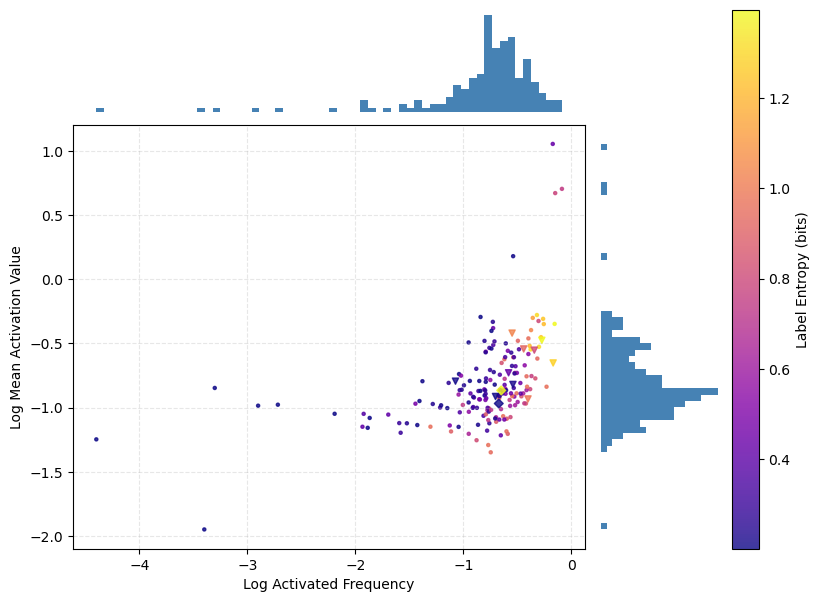

In [130]:
import src.sae_utils


importlib.reload(src.sae_utils)


src.sae_utils.plot_metrics_figure(stats,shapes=shapes)

In [298]:
best_n = 0
best_auc = 0
#nan_mask[638] = True
#nan_mask[1378] = True
#nan_mask[1141] = True
#nan_mask[1911] = True
#nan_mask[1684] = True
#nan_mask[2417] = True
#nan_mask[1564] = True
nan_mask[2207] = True
nan_mask[1986] = True
nan_mask[671] = True
nan_mask[1252] = True
for i in np.arange(2560)[~nan_mask]:
    mask_context = [671,1986,2207,1252,i]
    mahal_params = fit_mahalanobis(torch.tensor(train_latents.T[mask_context].T),np.array(tr_labels["sh"]),"tied_diag")
    maha_test = maha_score(mahal_params,torch.tensor(test).T[mask_context].T)[0]
    maha_obj = maha_score(mahal_params,torch.tensor(ood_shape).T[mask_context].T)[0]
    maha_ctx = maha_score(mahal_params,torch.tensor(ood_fh).T[mask_context].T)[0]

    classes_obj = [0]*len(maha_test) + [1]*(len(maha_obj))
    print(roc_auc_score(classes_obj, np.concatenate([maha_test,maha_obj])))
    classes_ctx= [0]*len(maha_test) + [1]*(len(maha_ctx))
    auc = roc_auc_score(classes_ctx, np.concatenate([maha_test,maha_ctx]))
    if auc < 0.5:
        auc = 1- auc
    if best_auc < auc:
        best_auc = auc
        best_n = i
    print("Object (should be better):", auc)

0.5890555340679293
Object (should be better): 0.6650934038059392
0.5973077204244848
Object (should be better): 0.6738186115122115
0.5570269344848966
Object (should be better): 0.5984056812366169
0.5920835787566681
Object (should be better): 0.6063767077405728
0.5997175262562482
Object (should be better): 0.6793300528357302
0.6113560668984467
Object (should be better): 0.665772279942477
0.5698177500034818
Object (should be better): 0.6678472903546319
0.597307728020591
Object (should be better): 0.6738186071168704
0.5525519030892716
Object (should be better): 0.6192066834085547
0.5973077204244848
Object (should be better): 0.6738191948367711
0.5926930042313894
Object (should be better): 0.66431394782231
0.5793966513849426
Object (should be better): 0.6710973490691686
0.5973069342274899
Object (should be better): 0.6738178683856062
0.5722869371296836
Object (should be better): 0.6494550446963434
0.5900017284813126
Object (should be better): 0.6377306728244676
0.5448952046185227
Object (sh

In [299]:
best_auc,best_n


(0.6952456562504336, 1252)

In [233]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(), LogisticRegression(penalty="l1", solver="saga"))
cl_data = np.concatenate([test,ood_fh])
classes_obj = [0]*len(test) + [1]*(len(ood_fh))
model.fit(cl_data, classes_ctx)

coef = model.named_steps["logisticregression"].coef_[0]
feature_importance = abs(coef)


In [276]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=200, random_state=0)
cl_data = np.concatenate([test,ood_fh])
classes_obj = [0]*len(test) + [1]*(len(ood_fh))
model.fit(cl_data, classes_ctx)

ctx_importances = model.feature_importances_

model = RandomForestClassifier(n_estimators=200, random_state=0)
cl_data = np.concatenate([test,ood_shape])
classes_obj = [0]*len(test) + [1]*(len(ood_shape))
model.fit(cl_data, classes_obj)

shape_importances = model.feature_importances_


In [302]:
from sklearn.metrics import accuracy_score
# training accuracy
y_pred_train = model.predict(cl_data)
train_acc = accuracy_score(classes_obj, y_pred_train)
print(f"Training accuracy: {train_acc:.4f}")

Training accuracy: 1.0000


In [291]:
ctx_rf_mask =np.arange(512*expansion_coef)[ctx_importances >= 0.02]
ctx_rf_mask

array([  29,  117,  645,  671, 1652])

In [290]:
obj_rf_mask= np.arange(512*expansion_coef)[shape_importances >= 0.02]
obj_rf_mask

array([ 131,  478,  671, 1747, 2239])

In [292]:
mask_context = ctx_rf_mask
mask_object = obj_rf_mask

In [231]:
shape_feat_importance = feature_importance

In [234]:
hue_feat_importance = feature_importance

In [264]:
ctx_log_reg_mask =np.arange(512*expansion_coef)[hue_feat_importance >= 0.3]
ctx_log_reg_mask

array([ 117,  671, 1273, 1652, 1747, 2040, 2207, 2361])

In [265]:
obj_log_reg_mask = np.arange(512*expansion_coef)[shape_feat_importance >= 0.5]
obj_log_reg_mask

array([  29,  131,  240,  671, 1460, 1747, 1929, 2089, 2264])

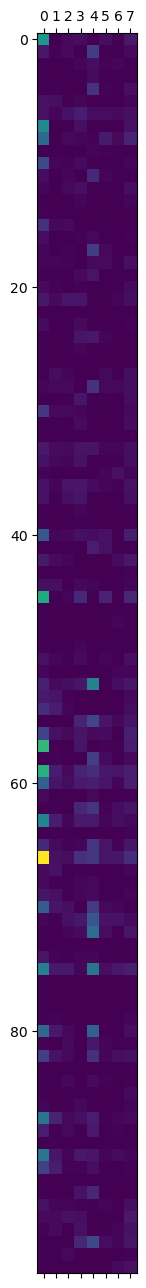

In [246]:
plt.matshow(np.concatenate([test[:50],ood_shape[:50]]).T[hue_feat_importance > 0.3].T)

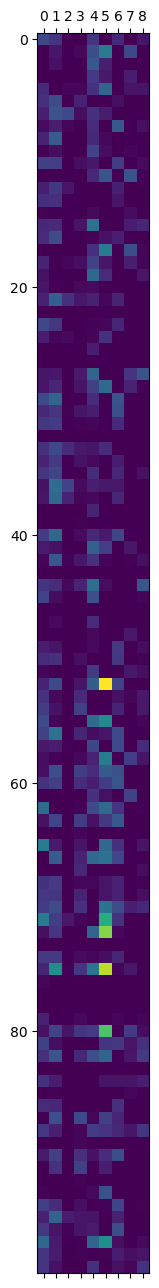

In [232]:
plt.matshow(np.concatenate([test[:50],ood_shape[:50]]).T[shape_feat_importance > 0.5].T)

In [262]:
mask_context = ctx_log_reg_mask
mask_object = obj_log_reg_mask

In [294]:
mahal_params = fit_mahalanobis(torch.tensor(train_latents.T[mask_context].T),np.array(tr_labels["sh"]),"tied_diag")
maha_test = maha_score(mahal_params,torch.tensor(test).T[mask_context].T)[0]
maha_obj = maha_score(mahal_params,torch.tensor(ood_shape).T[mask_context].T)[0]
maha_ctx = maha_score(mahal_params,torch.tensor(ood_fh).T[mask_context].T)[0]

classes_obj = [0]*len(maha_test) + [1]*(len(maha_obj))
print(roc_auc_score(classes_obj, np.concatenate([maha_test,maha_obj])))
classes_ctx= [0]*len(maha_test) + [1]*(len(maha_ctx))
print("context (should be better):", roc_auc_score(classes_ctx, np.concatenate([maha_test,maha_ctx])))

0.5312971806422515
context (should be better): 0.5193716152568877


In [206]:
mahal_params = fit_mahalanobis(torch.tensor(train_latents.T[mask_rest].T),np.array(tr_labels["sh"]),"tied_diag")
maha_test = maha_score(mahal_params,torch.tensor(test).T[mask_rest].T)[0]
maha_obj = maha_score(mahal_params,torch.tensor(ood_shape).T[mask_rest].T)[0]
maha_ctx = maha_score(mahal_params,torch.tensor(ood_fh).T[mask_rest].T)[0]

print("alls should be bad")
classes_obj = [0]*len(maha_test) + [1]*(len(maha_obj))
print(roc_auc_score(classes_obj, np.concatenate([maha_test,maha_obj])))
classes_ctx= [0]*len(maha_test) + [1]*(len(maha_ctx))
print( roc_auc_score(classes_ctx, np.concatenate([maha_test,maha_ctx])))

alls should be bad
0.5177984035919332
0.4795248480131533


tied_full:

tied_shrink:0.677

tied_diag:0.642


### Recon and sparsity 

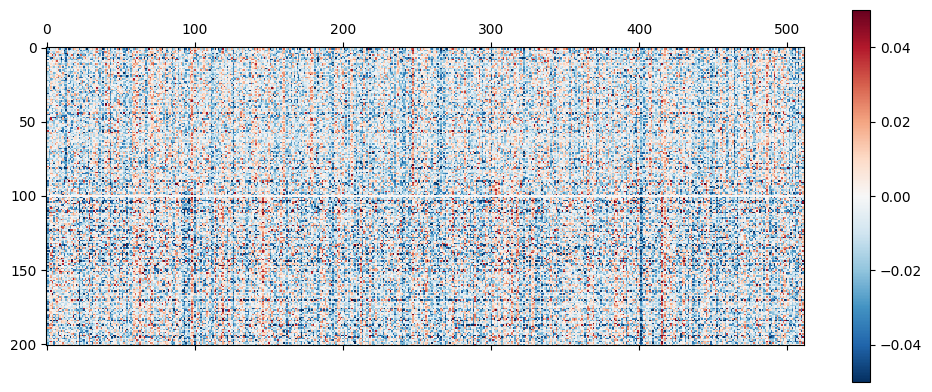

In [ ]:
diff_test = test_acts[:100] - test_latents[0][:100].detach().numpy()
diff_ood =  ood_acts[:100] - ood_latents[0][:100].detach().numpy()
plt.matshow(np.concatenate([diff_test,np.zeros((1,512)),diff_ood]), cmap='RdBu_r', vmin = -0.05, vmax = 0.05)

plt.colorbar()


In [ ]:
# 1) reconstruction
s_rec_test = (torch.tensor(test_acts) - test_latents[0]).pow(2).sum(-1).detach()   # L2^2
s_rec_ood =  (torch.tensor(ood_acts) - ood_latents[0]).pow(2).sum(-1).detach()   # L2^2

classes = [0]*len(s_rec_test) + [1]*len(s_rec_ood)
auc = roc_auc_score(classes, torch.cat([s_rec_test,s_rec_ood]))
plt.hist(s_rec_test,50, label="test",alpha = 0.5)
plt.hist(s_rec_ood,50, label="ood",alpha = 0.5)
plt.title(auc)
plt.legend()






IndexError: The shape of the mask [2560] at index 0 does not match the shape of the indexed tensor [9000, 512] at index 0

In [162]:
# 2) sparsity 
sparse_test = torch.tensor(test_latents[1]).T[mask_object].T.abs().sum(-1).detach()
sparse_ood = torch.tensor(test_latents[1]).T[mask_object].T.abs().sum(-1).detach()

classes = [0]*len(sparse_test) + [1]*len(sparse_ood)
auc = roc_auc_score(classes, torch.cat([sparse_test,sparse_ood]))
plt.hist(sparse_test,50, label="test",alpha = 0.5)
plt.hist(sparse_ood,50, label="ood",alpha = 0.5)
plt.title(auc)
plt.legend()






TypeError: len() of a 0-d tensor

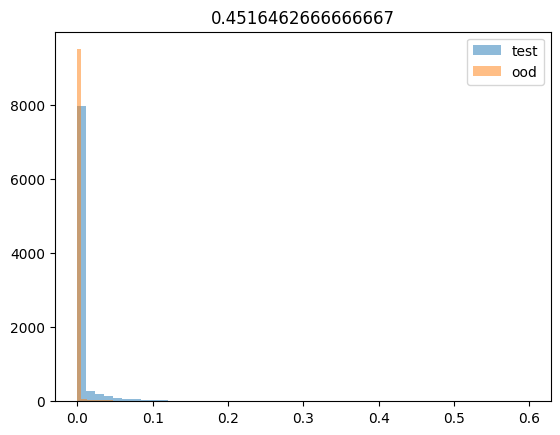

In [ ]:
# 2) sparsity 
sparse_test = test_latents[1].T[mask_context].T.abs().sum(-1).detach()
sparse_ood = ood_latents[1].T[mask_context].T.abs().sum(-1).detach()

classes = [0]*len(sparse_test) + [1]*len(sparse_ood)
auc = roc_auc_score(classes, torch.cat([sparse_test,sparse_ood]))
plt.hist(sparse_test,50, label="test",alpha = 0.5)
plt.hist(sparse_ood,50, label="ood",alpha = 0.5)
plt.title(auc)
plt.legend()




